## Naive Bayes Classifier on voice features

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
from jupyterthemes import jtplot
jtplot.style(theme='gruvboxd',context='notebook',grid=False,ticks=True)
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

Each voice sample is stored as a .WAV file, which is then pre-processed for acoustic analysis using the specan function from the WarbleR R package. Specan measures 22 acoustic parameters on acoustic signals for which the start and end times are provided.

The output from the pre-processed WAV files were saved into a CSV file, containing 3168 rows and 21 columns (20 columns for each feature and one label column for the classification of male or female). You can download the pre-processed dataset in CSV format, using the link above.

Note, the features for duration and peak frequency (peakf) were removed from training. Duration refers to the length of the recording, which for training, is cut off at 20 seconds. Peakf was omitted from calculation due to time and CPU constraints in calculating the value. In this case, all records will have the same value for duration (20) and peak frequency (0).

In [2]:
# importing data
df = pd.read_csv("C:/Users/R3M0/Documents/EE 413 Pattern Recognition and Machine Learning Laboratory/PRML/voice.csv");
# data shape and visualisation
print(df.shape);
df.head()

(3168, 21)


,meanfreq,sd,median,Q25,Q75,IQR,skew,kurt,sp.ent,sfm,...,centroid,meanfun,minfun,maxfun,meandom,mindom,maxdom,dfrange,modindx,label
0,0.059781,0.064241,0.032027,0.015071,0.090193,0.075122,12.863462,274.402906,0.893369,0.491918,...,0.059781,0.084279,0.015702,0.275862,0.007812,0.007812,0.007812,0.000000,0.000000,male
1,0.066009,0.067310,0.040229,0.019414,0.092666,0.073252,22.423285,634.613855,0.892193,0.513724,...,0.066009,0.107937,0.015826,0.250000,0.009014,0.007812,0.054688,0.046875,0.052632,male
2,0.077316,0.083829,0.036718,0.008701,0.131908,0.123207,30.757155,1024.927705,0.846389,0.478905,...,0.077316,0.098706,0.015656,0.271186,0.007990,0.007812,0.015625,0.007812,0.046512,male
3,0.151228,0.072111,0.158011,0.096582,0.207955,0.111374,1.232831,4.177296,0.963322,0.727232,...,0.151228,0.088965,0.017798,0.250000,0.201497,0.007812,0.562500,0.554688,0.247119,male
4,0.135120,0.079146,0.124656,0.078720,0.206045,0.127325,1.101174,4.333713,0.971955,0.783568,...,0.135120,0.106398,0.016931,0.266667,0.712812,0.007812,5.484375,5.476562,0.208274,male


In [3]:
# removing headers and extracting labels
x = np.array(df[df.columns[0:df.shape[1]-1]]);
y = np.array(df['label']);
# mapping labels to 0 (male) and 1 (female) as NB function labels need to be integers
y = 0*(y=='male')+1*(y=='female');

print("Dataset shape: (examples,features) :",x.shape);
# print(type(x));

print("Labels shape: ",y.shape);
# print(type(y));

Dataset shape: (examples,features) : (3168, 20)
Labels shape:  (3168,)


In [4]:
# fit a probability distribution to a univariate data sample
# P(Xi|yi) - P(data|class) - likelihood
def uni_norm_dist(data):
    # estimate parameters
    mu = np.mean(data);
    sigma = np.std(data);
    # print(mu,sigma);
    # fit distribution
    dist = norm(mu, sigma);
    return dist
 
# calculate the independent conditional probability and predict
# P(yi | x1, x2, …, xn) = P(x1, x2, …, xn | yi) * P(yi) / P(x1, x2, …, xn) = P(class|data) = (P(data|class) * P(class)) / P(data)
#  the denominator is removed from the calculation P(x1, x2, …, xn) as it is a constant 
def predict_class(X, priory_, distX_y_,n,l):
    y = np.array([]);
    for j in range(l):
        prob = priory_[j]; # p(yi) = priori probability
        for i in range(n):
            prob*= distX_y_[str(i)+str(j)].pdf(X[i]); # prob = P(class|data) = P(yi|x1,x2,…,xn) = P(yi)*P(x1,x2,…,xn|yi)= posteriori probability
        y = np.append(y,prob);
    return np.argmax(y)

#Naive Bayesian Classifier
def NB_class(X,y):
    labels = np.unique(y);
    # print(X.shape)
    # sort data into classes
    Xy_={};
    for i in labels:
        Xy_[i] = X[y==i];
    # calculate priors
    priory_ = {}
    for i in labels:
        priory_[i] = len(Xy_[i])/len(X);
    # PDFs 
    distX_y_ = {};
    for i in range(X.shape[1]):
        for j in labels:
            distX_y_[str(i)+str(j)] = uni_norm_dist(Xy_[j][:,i]);
    return priory_,distX_y_,labels

# Predicting labels from model parameters
def NB_fit(X,priory_,distX_y_,labels):
    # predicting samples
    pred = np.array([]);
    for i in range(X.shape[0]):
        pred = np.append(pred,predict_class(X[i,:],priory_,distX_y_,X.shape[1],len(labels)))
    return pred;

In [5]:
# train, test split
x_train,x_test,y_train,y_test=train_test_split(x,y,stratify=y,test_size=0.15);

# training to get model parameters
priory,distXy,labels = NB_class(x_train,y_train);

# predicting
pred_train = NB_fit(x_train,priory,distXy,labels);
pred_test = NB_fit(x_test,priory,distXy,labels);

Train Accuracy: 89.26448736998515


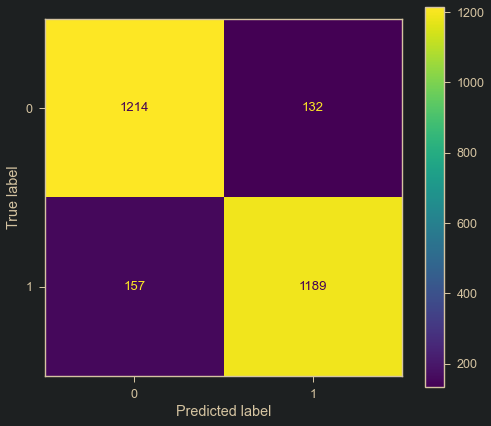

In [6]:
# train data metrics
acc = np.sum(pred_train == y_train)*100/len(pred_train);
print("Train Accuracy:",acc);
ConfusionMatrixDisplay(confusion_matrix(y_train,pred_train)).plot();

Test Accuracy: 89.07563025210084


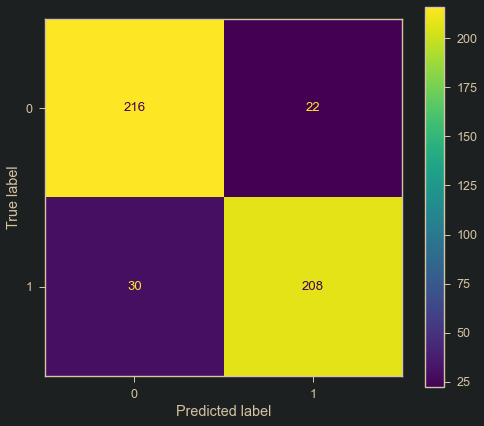

In [7]:
# test data metrics
acc = np.sum(pred_test == y_test)*100/len(pred_test);
print("Test Accuracy:",acc);
ConfusionMatrixDisplay(confusion_matrix(y_test,pred_test)).plot();

Sci-kit Learn library to perform Gaussian Naive Bayes classifier on the above dataset

Training Accuracy: 88.8187221396731
Training : Confusion Matrix:


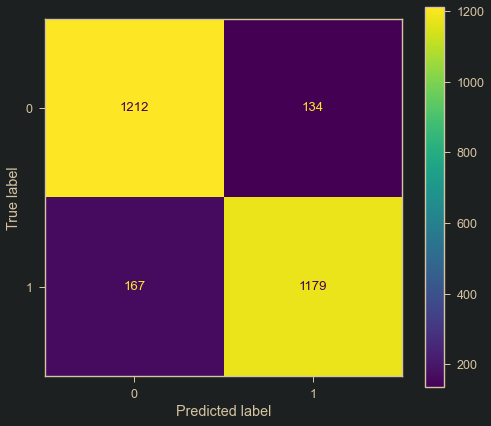

In [8]:
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score
from sklearn.metrics import plot_confusion_matrix

model = GaussianNB();
model.fit(x_train, y_train);
print("Training Accuracy:",model.score(x_train, y_train)*100);
print("Training : Confusion Matrix:");
plot_confusion_matrix(model,x_train,y_train);

Testing Accuracy: 88.65546218487394
Test : Confusion Matrix:


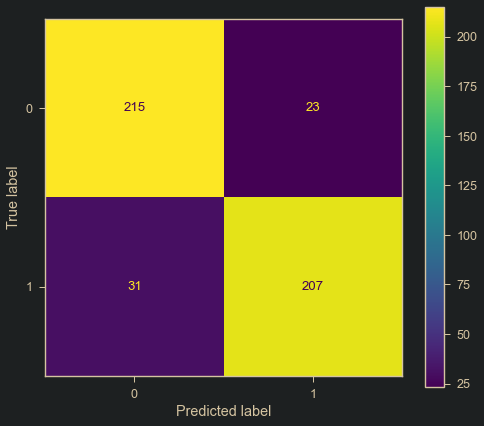

In [9]:
print("Testing Accuracy:",model.score(x_test, y_test)*100);
print("Test : Confusion Matrix:");
plot_confusion_matrix(model,x_test,y_test);

In [10]:
# visualising the means and variances per class
for i in range(x.shape[1]):
    for j in range(len(labels)):
        mean, var = distXy[str(i)+str(j)].stats();
        print("\nClass "+str(j) + "; Feature " + str(i+1) + "; " + df.columns[i]);
        print("mean : " + str(mean));
        print("var  : " + str(var));


Class 0; Feature 1; meanfreq
mean : 0.1708566791484828
var  : 0.000710001109658489

Class 1; Feature 1; meanfreq
mean : 0.1909734373736634
var  : 0.0009082517528805474

Class 0; Feature 2; sd
mean : 0.0650635867433033
var  : 9.036333719445713e-05

Class 1; Feature 2; sd
mean : 0.04922658423834146
var  : 0.00033815207169433963

Class 0; Feature 3; median
mean : 0.17537365988343506
var  : 0.0014401732540281727

Class 1; Feature 3; median
mean : 0.19597426854927205
var  : 0.0010428879692123598

Class 0; Feature 4; Q25
mean : 0.11552817810313129
var  : 0.0010620061113715046

Class 1; Feature 4; Q25
mean : 0.16507210317526919
var  : 0.002510109656496411

Class 0; Feature 5; Q75
mean : 0.22625497866673558
var  : 0.0005845595111472532

Class 1; Feature 5; Q75
mean : 0.22327762450822086
var  : 0.0005397716457153347

Class 0; Feature 6; IQR
mean : 0.11072680056360429
var  : 0.0004217151629563805

Class 1; Feature 6; IQR
mean : 0.058205521332951676
var  : 0.0018507429489200557

Class 0; Feature